In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly as py
import plotly.graph_objs as go
import requests
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
plt.style.use('bmh')

In [5]:
'''
https://poloniex.com/support/api
https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1405699200&end=9999999999&period=86400
'''

'\nhttps://poloniex.com/support/api\nhttps://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1405699200&end=9999999999&period=86400\n'

In [6]:
ret = requests.get('https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1405699200&end=9999999999&period=86400')
ret

<Response [200]>

In [9]:
json = ret.json()
df = pd.DataFrame(json)

scaler = MinMaxScaler()
df[['close']] = scaler.fit_transform(df[['close']])
# close를 minmaxscaler로 트랜스폼해서 다시 넣어준다.
df

,date,high,low,open,close,volume,quoteVolume,weightedAverage
0,1424304000,244.000000,225.000000,225.000000,0.003428,4.627631e+01,0.193117,239.627778
1,1424390400,245.000000,240.250000,240.250118,0.003231,5.589490e+01,0.230429,242.568479
2,1424476800,245.000000,245.000000,245.000000,0.003480,1.472224e+01,0.060091,245.000000
3,1424563200,249.000000,235.000000,245.000000,0.002955,1.291212e+02,0.539055,239.532608
4,1424649600,235.001000,235.000000,235.000002,0.002955,9.656756e+01,0.410926,235.000062
...,...,...,...,...,...,...,...,...
1886,1587254400,7263.949781,7055.000000,7249.742401,0.364616,1.335513e+07,1866.966396,7153.384507
1887,1587340800,7215.454579,6754.986856,7121.346303,0.349208,1.858451e+07,2656.585146,6995.637405
1888,1587427200,6940.078300,6750.000000,6830.656600,0.349933,1.341686e+07,1958.331865,6851.166753
1889,1587513600,7151.789008,6819.720025,6842.936459,0.364709,1.450904e+07,2068.616170,7013.886946


In [14]:
price = df['close'].values.tolist()
#df에서 종가를 가져와서 배열에 때려넣음.


In [19]:
'''
Many to many
X
 0.0034278368698297933,
 0.0032309273586996947,
 0.0034803460727978203,
Y
 0.0029552540431175573,
 0.0029552540431175573,
Many to one
(batch, 5,1)
X
 0.0034278368698297933,
 0.0032309273586996947,
 0.0034803460727978203,
 0.0029552540431175573,
 0.0029552540431175573,
Y
(batch, 1)
 0.003204672757215681,
(그 다음값.)

'''

window_size = 5
X = []
Y = []
for i in range(len(price)- window_size):
    # i = 0
    # j = 0,1,2,3,4
    X.append([price[i+j] for j in range(window_size)])
    Y.append(price[window_size+i])


In [22]:
X = np.asarray(X)
Y = np.asarray(Y)

print(X)
print(Y)

[[0.00342784 0.00323093 0.00348035 0.00295525 0.00295525]
 [0.00323093 0.00348035 0.00295525 0.00295525 0.00320467]
 [0.00348035 0.00295525 0.00295525 0.00320467 0.00309965]
 ...
 [0.36358689 0.35964887 0.37127475 0.36461633 0.34920784]
 [0.35964887 0.37127475 0.36461633 0.34920784 0.34993273]
 [0.37127475 0.36461633 0.34920784 0.34993273 0.36470923]]
[0.00320467 0.00309965 0.00313904 ... 0.34993273 0.36470923 0.36726909]


In [23]:
X.shape

(1886, 5)

In [24]:
Y.shape

(1886,)

In [26]:
train_test_split = 1700
# 첫번째 행부터 1000번째까지 자른다. 두번째 파람 : 는 전체를 의미한다.
X_train = X[:train_test_split,:]
Y_train = Y[:train_test_split]
# 1000번째 부터. 두번째 파람 : 는 전체를 의미한다.
X_test = X[train_test_split:,:]
Y_test = Y[train_test_split:]

In [27]:
Y_train.shape

(1700,)

In [28]:
X_train.shape

(1700, 5)

In [29]:
X_test.shape

(186, 5)

In [30]:
Y_test.shape

(186,)

In [31]:
X_train = np.reshape(X_train, (X_train.shape[0], window_size, 1))
X_test = np.reshape(X_test, (X_test.shape[0], window_size, 1))

X_train[0]

array([[0.00342784],
       [0.00323093],
       [0.00348035],
       [0.00295525],
       [0.00295525]])

In [32]:
X_train.shape

(1700, 5, 1)

In [57]:
model = Sequential()
model.add(LSTM(128, input_shape=(5,1,)))
model.add(Dropout(0,2))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [58]:
model.fit(X_train, Y_train, epochs=20, batch_size=1,)

Epoch 1/20
1700/1700 [==============================] - 5s 3ms/step - loss: 0.0015
Epoch 2/20
1700/1700 [==============================] - 5s 3ms/step - loss: 8.0323e-04
Epoch 3/20
1700/1700 [==============================] - 5s 3ms/step - loss: 6.3737e-04
Epoch 4/20
1700/1700 [==============================] - 5s 3ms/step - loss: 5.3461e-04
Epoch 5/20
1700/1700 [==============================] - 5s 3ms/step - loss: 4.1545e-04
Epoch 6/20
1700/1700 [==============================] - 5s 3ms/step - loss: 3.6035e-04
Epoch 7/20
1700/1700 [==============================] - 5s 3ms/step - loss: 3.8988e-04
Epoch 8/20
1700/1700 [==============================] - 5s 3ms/step - loss: 3.7005e-04
Epoch 9/20
1700/1700 [==============================] - 5s 3ms/step - loss: 3.4207e-04
Epoch 10/20
1700/1700 [==============================] - 5s 3ms/step - loss: 3.9258e-04
Epoch 11/20
1700/1700 [==============================] - 5s 3ms/step - loss: 3.3115e-04
Epoch 12/20
1700/1700 [======================

In [59]:
train_prdeict = model.predict(X_train)
test_predict = model.predict(X_test)


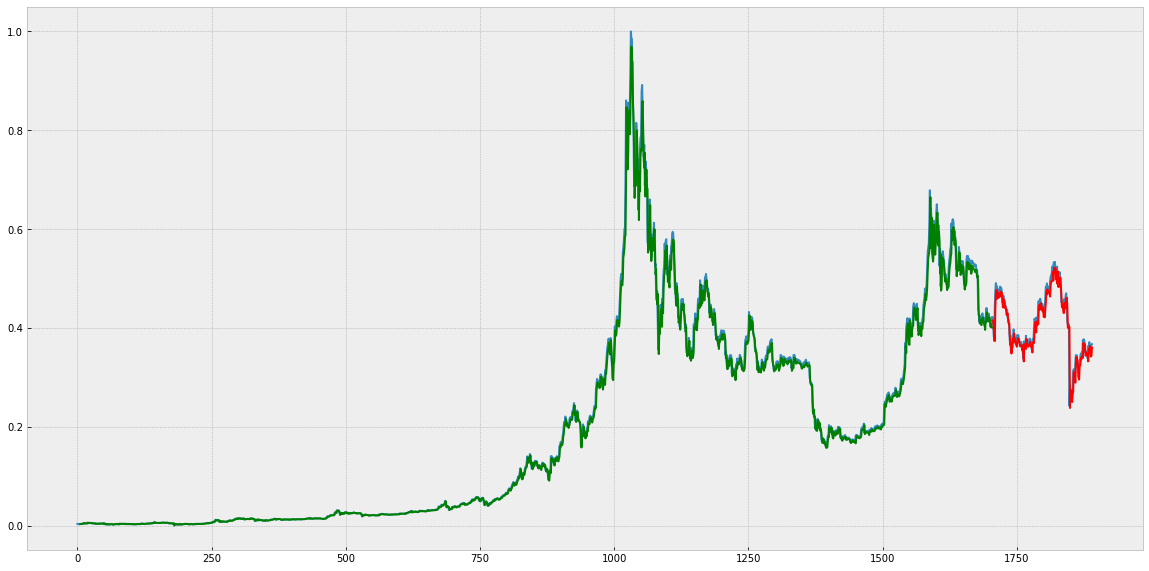

In [61]:
plt.figure(figsize=(20,10))
plt.plot(price)

split_pt = train_test_split + window_size
plt.plot(np.arange(window_size, split_pt, 1), train_prdeict, color='g')

plt.plot(np.arange(split_pt, split_pt+len(test_predict), 1), test_predict, color = 'r')

In [63]:


trace = go.Scatter(x=np.arange(window_size, split_pt, 1), y=train_prdeict.reshape(1700), mode='lines', name = 'train')
trace2 = go.Scatter(x=np.arange(split_pt, split_pt+len(test_predict), 1), y=test_predict.reshape(186), mode='lines', name = 'test')
trace3 = go.Scatter(x=np.arange(1, len(price), 1), y=price, mode='lines', name = 'original')

data = [trace, trace2, trace3]
py.offline.plot(data)

'temp-plot.html'